In [1]:
import os
import pandas as pd
import yaml
import torch
import collections

import warnings

warnings.filterwarnings("ignore")

In [2]:
def process_experiment(root_dir):
    rows = []

    for name in os.listdir(root_dir):
        experiment_path = os.path.join(root_dir, name)
        if os.path.isdir(experiment_path):
            for seed_name in os.listdir(experiment_path):
                seed_path = os.path.join(experiment_path, seed_name)
                if os.path.isdir(seed_path):
                    row_data = process_subexperiment(
                        seed_path, os.path.basename(root_dir)
                    )
                    rows.extend(row_data)  # Extend to add multiple rows

    # Create a DataFrame from the rows
    df = pd.DataFrame(rows)
    return df


def process_subexperiment(seed_folder_path, experiment_name):
    cfg_data = read_config(os.path.join(seed_folder_path, "cfg.yaml"), experiment_name)
    train_stats_file = find_train_stats_file(seed_folder_path)
    if train_stats_file:
        experiment_results = process_training_stats(train_stats_file, cfg_data)
        return experiment_results
    else:
        return []  # Return an empty list if no train stats file is found


def read_config(cfg_path, experiment_name):
    with open(cfg_path, "r") as file:
        config = yaml.safe_load(file)
        full_title = config.get("full_title", "")
        variable_part = remove_experiment_name(full_title, experiment_name)
        return parse_config_variables(variable_part)


def remove_experiment_name(full_title, experiment_name):
    to_remove = experiment_name + "_"
    return (
        full_title[len(to_remove) :].strip()
        if full_title.startswith(to_remove)
        else full_title
    )


def parse_config_variables(variable_str):
    variables = {}
    for part in variable_str.split(";"):
        if "=" in part:
            key, value = part.split("=", 1)
            variables[key.strip()] = value.strip()
    return variables


def find_train_stats_file(folder_path):
    for file in os.listdir(folder_path):
        if file.endswith("_train_stats"):
            return os.path.join(folder_path, file)
    return None


def process_training_stats(train_stats_file, cfg_data):
    checkpoint = torch.load(train_stats_file)

    # Assuming the checkpoint contains 'training_stats' and 'validation_stats'
    training_stats = checkpoint.get("training_stats", [])
    validation_stats = checkpoint.get("validation_stats", [])

    # Process each stats type and return combined results
    return process_stats(training_stats, cfg_data, "training") + process_stats(
        validation_stats, cfg_data, "validation"
    )


def process_stats(stats, cfg_data, stats_type):
    records = []
    for epoch_stats in stats:
        record = {"epoch_type": stats_type}
        record.update(flatten(epoch_stats))  # Flatten the epoch_stats if it's nested
        record.update(cfg_data)  # Add configuration data
        records.append(record)
    return records


def flatten(d, parent_key="", sep="_"):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.abc.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [3]:
df = process_experiment(
    r"D:\Work\repos\RL\minatar_work\experiments\training\training_with_redo\results\2023Nov24-190816_configs"
)
df.columns

Index(['epoch_type', 'frame_stamp', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_frames_min', 'episode_frames_max',
       'episode_frames_mean', 'episode_frames_median', 'episode_frames_std',
       'episode_losses_min', 'episode_losses_max', 'episode_losses_mean',
       'episode_losses_median', 'episode_losses_std', 'episode_max_qs_min',
       'episode_max_qs_max', 'episode_max_qs_mean', 'episode_max_qs_median',
       'episode_max_qs_std', 'policy_trained_times', 'target_trained_times',
       'epoch_time', 'redo.redo_freq', 'redo.tau',
       'agent_params.args_.target_model_update_freq', 'environment'],
      dtype='object')

In [4]:
df

,epoch_type,frame_stamp,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_frames_min,episode_frames_max,episode_frames_mean,...,episode_max_qs_mean,episode_max_qs_median,episode_max_qs_std,policy_trained_times,target_trained_times,epoch_time,redo.redo_freq,redo.tau,agent_params.args_.target_model_update_freq,environment
0,training,200000,0.0,8.0,0.810385,0.0,1.086088,6,96,14.400547,...,-78.015270,-78.479939,8.218055,48749.0,1948.0,0 days 00:17:44.688907,500,0.01,100,breakout
1,training,400000,0.0,20.0,2.411858,2.0,1.876920,6,154,31.706722,...,-70.435876,-69.278061,10.358919,50000.0,2000.0,0 days 00:13:11.076816,500,0.01,100,breakout
2,training,600000,0.0,20.0,3.157853,3.0,2.242268,6,154,39.913790,...,-70.407412,-67.477913,12.956225,50000.0,2000.0,0 days 00:13:34.229498,500,0.01,100,breakout
3,training,800000,0.0,16.0,4.125505,4.0,2.792334,6,162,50.507071,...,-66.089790,-63.118515,12.188790,50000.0,2000.0,0 days 00:13:16.594822,500,0.01,100,breakout
4,training,1000000,0.0,21.0,3.959322,4.0,2.271689,6,164,48.426150,...,-66.276626,-62.936769,12.248967,50000.0,2000.0,0 days 00:13:18.401245,500,0.01,100,breakout
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,validation,3200000,0.0,8.0,0.995560,1.0,1.284235,26,460,138.819090,...,-41.996041,-40.389380,9.675001,NaN,NaN,0 days 00:02:00.128753,1000,0.05,1000,asterix
956,validation,3400000,0.0,9.0,1.013393,1.0,1.323651,26,521,139.570312,...,-41.570460,-39.609493,10.176275,NaN,NaN,0 days 00:02:00.832147,1000,0.05,1000,asterix
957,validation,3600000,0.0,9.0,0.998884,1.0,1.245975,26,626,139.621652,...,-41.790797,-39.810825,9.745561,NaN,NaN,0 days 00:01:58.374853,1000,0.05,1000,asterix
958,validation,3800000,0.0,8.0,0.994493,1.0,1.230564,22,618,137.723568,...,-43.353271,-41.380093,10.040418,NaN,NaN,0 days 00:01:44.158412,1000,0.05,1000,asterix


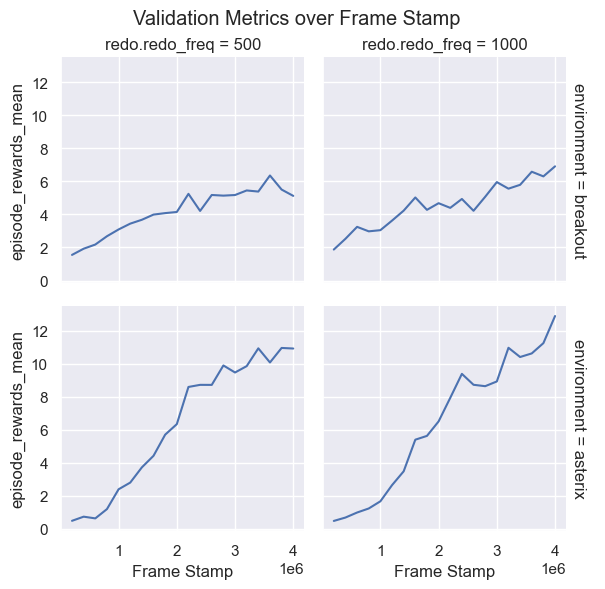

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Assuming 'df' is your DataFrame
# Filter for rows where epoch_type is 'validation'
validation_df = df[df['epoch_type'] == 'validation']

# Define your selected_metric and selected_var
selected_metric = 'episode_rewards_mean'  
selected_var = 'redo.redo_freq'  

# Create the FacetGrid
g = sns.FacetGrid(validation_df, row='environment', col=selected_var, margin_titles=True, height=3)
g.map(sns.lineplot, 'frame_stamp', selected_metric, ci=None)

# Optional: Adjust the plot's aesthetics
g.set_axis_labels('Frame Stamp', selected_metric)
g.add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Validation Metrics over Frame Stamp')

# Show the plot
plt.show()

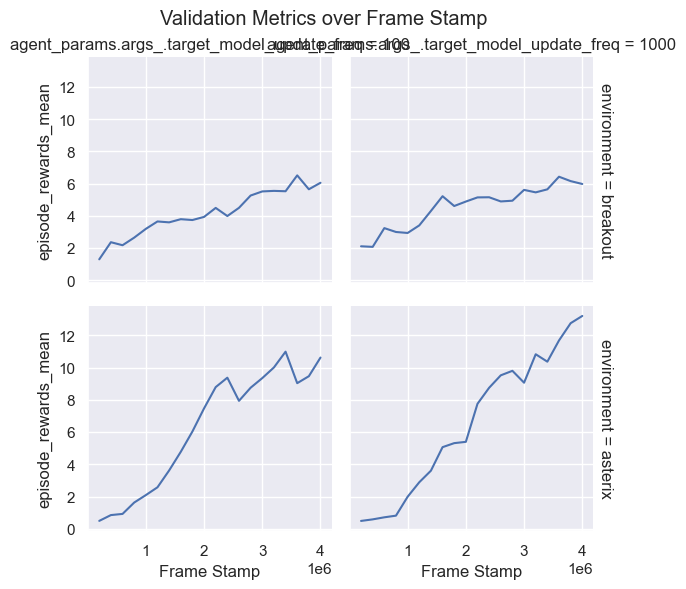

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Assuming 'df' is your DataFrame
# Filter for rows where epoch_type is 'validation'
validation_df = df[df['epoch_type'] == 'validation']

# Define your selected_metric and selected_var
selected_metric = 'episode_rewards_mean'  
selected_var = 'agent_params.args_.target_model_update_freq'  

# Create the FacetGrid
g = sns.FacetGrid(validation_df, row='environment', col=selected_var, margin_titles=True, height=3)
g.map(sns.lineplot, 'frame_stamp', selected_metric, ci=None)

# Optional: Adjust the plot's aesthetics
g.set_axis_labels('Frame Stamp', selected_metric)
g.add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Validation Metrics over Frame Stamp')

# Show the plot
plt.show()

Plotting for environment: breakout
redo.redo_freq redo.tau agent_params.args_.target_model_update_freq


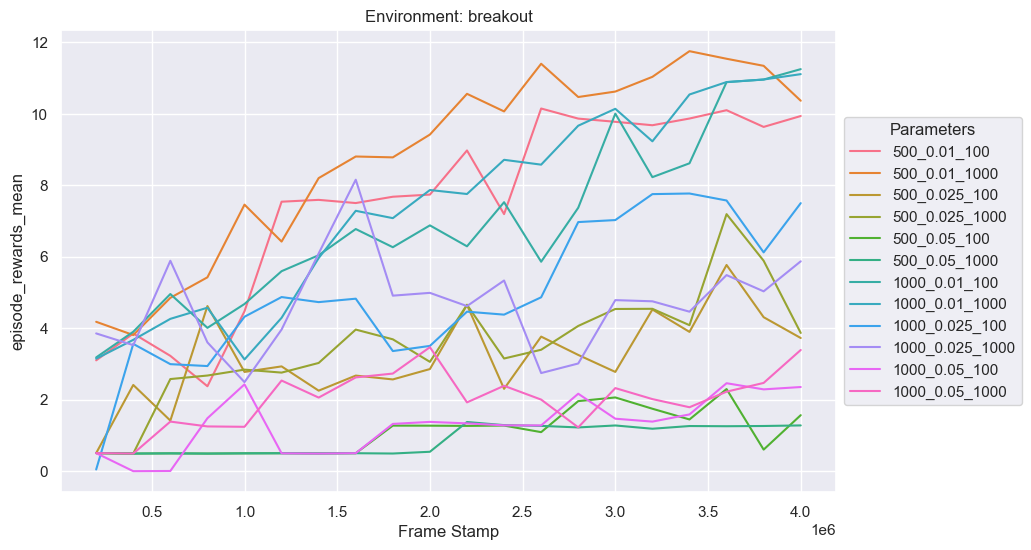

Plotting for environment: asterix
redo.redo_freq redo.tau agent_params.args_.target_model_update_freq


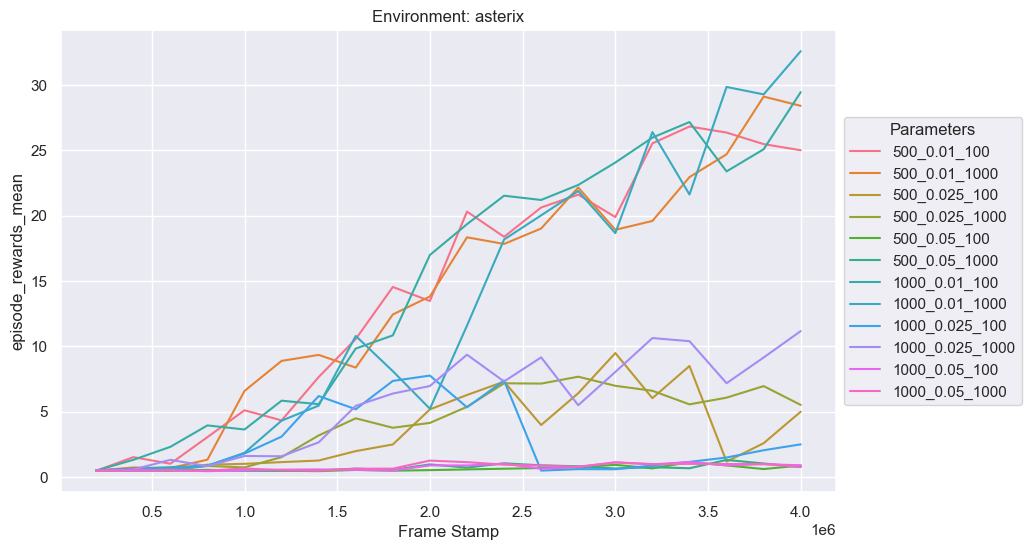

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

selected_metric = 'episode_rewards_mean'

validation_df = df[df['epoch_type'] == 'validation']

# Extract unique environments
environments = validation_df['environment'].unique()

for env in environments:
    env_df = validation_df[validation_df['environment'] == env]
    env_df['parameters'] = env_df[['redo.redo_freq', 'redo.tau', 
                                   'agent_params.args_.target_model_update_freq']].apply(lambda x: '_'.join(x.astype(str)), axis=1)
    
    print(f'Plotting for environment: {env}')
    print('redo.redo_freq', 'redo.tau', 'agent_params.args_.target_model_update_freq')
    
    # Create a new figure for each environment
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=env_df, x='frame_stamp', y=selected_metric, hue='parameters')
    plt.title(f'Environment: {env}')
    plt.ylabel(selected_metric)
    plt.xlabel('Frame Stamp')

    # Place the legend outside the plot
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Parameters')
    plt.show()

Plotting for environment: breakout
redo.redo_freq redo.tau agent_params.args_.target_model_update_freq


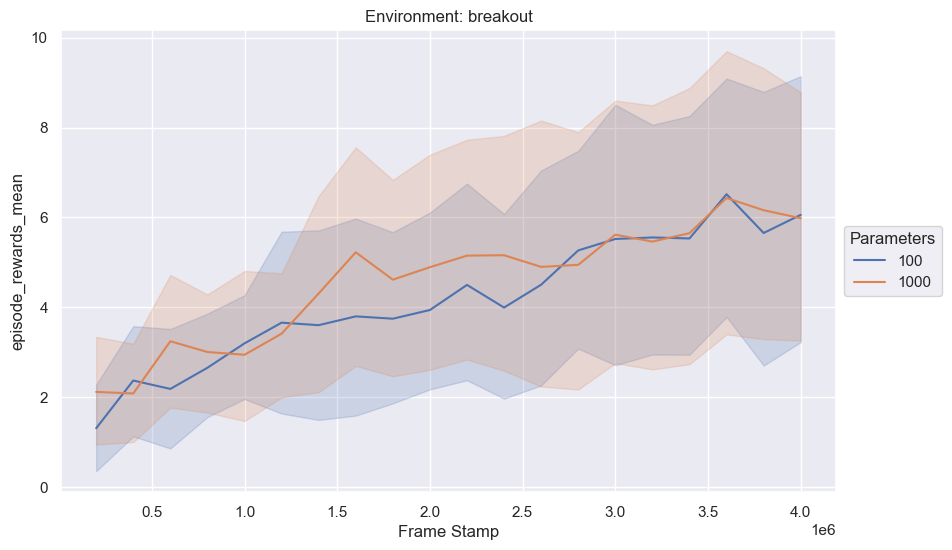

Plotting for environment: asterix
redo.redo_freq redo.tau agent_params.args_.target_model_update_freq


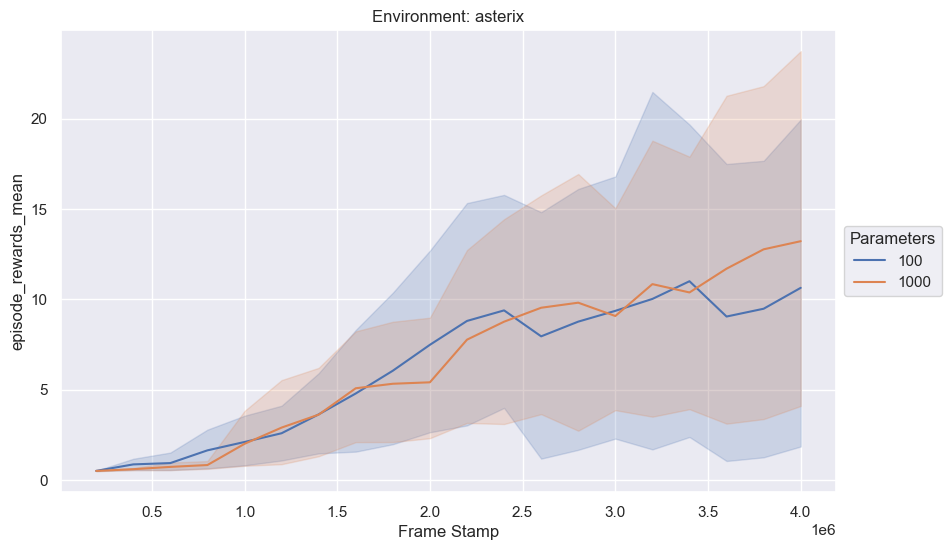

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

selected_metric = 'episode_rewards_mean'

validation_df = df[df['epoch_type'] == 'validation']

# Extract unique environments
environments = validation_df['environment'].unique()

for env in environments:
    env_df = validation_df[validation_df['environment'] == env]
    env_df['parameters'] = env_df[['agent_params.args_.target_model_update_freq']].apply(lambda x: '_'.join(x.astype(str)), axis=1)
    
    print(f'Plotting for environment: {env}')
    print('redo.redo_freq', 'redo.tau', 'agent_params.args_.target_model_update_freq')
    
    # Create a new figure for each environment
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=env_df, x='frame_stamp', y=selected_metric, hue='parameters')
    plt.title(f'Environment: {env}')
    plt.ylabel(selected_metric)
    plt.xlabel('Frame Stamp')

    # Place the legend outside the plot
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Parameters')
    plt.show()

In [1]:
import os, sys


def get_dir_n_levels_up(path, n):
    # Go up n levels from the given path
    for _ in range(n):
        path = os.path.dirname(path)
    return path


proj_root = get_dir_n_levels_up(os.path.abspath("."), 3)
sys.path.append(proj_root)

import yaml
import itertools
from pathlib import Path
import datetime
import multiprocessing
import traceback
from typing import List, Dict, Tuple

from liftoff import parse_opts


from minatar_dqn.utils import my_logging
from minatar_dqn import my_dqn
from experiments.experiment_utils import seed_everything
from experiments.training.training import create_path_to_experiment_folder

In [2]:
def convert_namespace_to_dict(obj):
    if isinstance(obj, dict):
        return {k: convert_namespace_to_dict(v) for k, v in obj.items()}
    elif hasattr(obj, "__dict__"):
        return {k: convert_namespace_to_dict(v) for k, v in obj.__dict__.items()}
    else:
        return obj

In [3]:
with open(r"D:\Work\repos\RL\minatar_work\experiments\training\training_with_redo\results\2023Nov24-190816_configs\0000_redo.redo_freq_500__redo.tau_0.01__agent_params.args_.target_model_update_freq_100__environment_breakout\0\cfg.yaml", 'r') as file:
    config = yaml.safe_load(file)
config = convert_namespace_to_dict(config)
config

{'agent_params': {'agent': 'AgentDQN',
  'args_': {'batch_size': 32,
   'epsilon': {'decay': 250000, 'end': 0.01, 'start': 1.0},
   'gamma': 0.99,
   'loss_fcn': 'mse_loss',
   'replay_start_size': 5000,
   'target_model_update_freq': 100,
   'train_step_cnt': 200000,
   'training_freq': 4,
   'validation_enabled': True,
   'validation_epsilon': 0.001,
   'validation_step_cnt': 125000}},
 'cfg_id': 0,
 'environment': 'breakout',
 'epochs_to_train': 20,
 'estimator': {'args_': {'conv_hidden_out_size': 32,
   'lin_hidden_out_size': 128},
  'model': 'Conv_QNET'},
 'experiment': 'redo_experiment',
 'experiment_arguments': {'agent_params': {'args_': {'target_model_update_freq': 100}},
  'environment': 'breakout',
  'redo': {'redo_freq': 500, 'tau': 0.01}},
 'full_title': '2023Nov24-190816_configs_redo.redo_freq=500; redo.tau=0.01; agent_params.args_.target_model_update_freq=100; environment=breakout',
 'optim': {'args_': {'eps': 0.00015, 'lr': 6.25e-05}, 'name': 'Adam'},
 'out_dir': '.\\res

In [4]:
config["estimator"]

{'args_': {'conv_hidden_out_size': 32, 'lin_hidden_out_size': 128},
 'model': 'Conv_QNET'}

In [5]:
# config = convert_namespace_to_dict(opts)

seed = int(os.path.basename(config["out_dir"]))

seed_everything(seed)

logs_file = os.path.join(config["out_dir"], "experiment_log.log")

logger = my_logging.setup_logger(
    name=config["experiment"],
    log_file=logs_file,
)

logger.info(f"Starting experiment: {config['full_title']}")

### Setup environments ###
train_env = my_dqn.build_environment(
    game_name=config["environment"], random_seed=seed
)
validation_env = my_dqn.build_environment(
    game_name=config["environment"], random_seed=seed
)

### Setup output and loading paths ###

path_previous_experiments_outputs = None
if "restart_training_timestamp" in config:
    path_previous_experiments_outputs = create_path_to_experiment_folder(
        config,
        config["out_dir"],
        config["restart_training_timestamp"],
    )

experiment_agent = my_dqn.AgentDQN(
    train_env=train_env,
    validation_env=validation_env,
    experiment_output_folder=config["out_dir"],
    experiment_name=config["experiment"],
    resume_training_path=path_previous_experiments_outputs,
    save_checkpoints=True,
    logger=logger,
    config=config,
    enable_tensorboard_logging=False,
)

2023-11-26 02:27:19,288 - redo_experiment - INFO - Starting experiment: 2023Nov24-190816_configs_redo.redo_freq=500; redo.tau=0.01; agent_params.args_.target_model_update_freq=100; environment=breakout
2023-11-26 02:27:19,293 - redo_experiment - INFO - Loaded configuration settings.
2023-11-26 02:27:19,300 - redo_experiment - INFO - Initialized newtworks and optimizer.
2023-11-26 02:27:19,301 - redo_experiment - INFO - Applied redo parametrization to policy model.
2023-11-26 02:27:19,302 - redo_experiment - INFO - Applied redo parametrization to target model.


c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment MinAtar/Breakout-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\utils\passive_env_checker.py:20: UserWarning: WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: bool. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.
  logger.warn(
c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\utils\passive_env_checker.py:25: UserWarning: WARN: It seems a Box observation space is an image but the upper and lower bounds are not in [0, 255]. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.
  logger.warn(


In [6]:
experiment_agent.policy_model

Conv_QNET(
  (features): Sequential(
    (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (relu2): ReLU()
  )
  (fc): Sequential(
    (lin1): Linear(in_features=1152, out_features=128, bias=True)
    (relu3): ReLU()
    (lin2): Linear(in_features=128, out_features=6, bias=True)
  )
)

In [8]:
import torch

checkpoint = torch.load(r"D:\Work\repos\RL\minatar_work\experiments\training\training_with_redo\results\2023Nov24-190816_configs\0000_redo.redo_freq_500__redo.tau_0.01__agent_params.args_.target_model_update_freq_100__environment_breakout\0\model_checkpoints\mck_20")
experiment_agent.policy_model.load_state_dict(checkpoint["policy_model_state_dict"])

<All keys matched successfully>

In [12]:
experiment_agent.policy_model

Conv_QNET(
  (features): Sequential(
    (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (relu2): ReLU()
  )
  (fc): Sequential(
    (lin1): Linear(in_features=1152, out_features=128, bias=True)
    (relu3): ReLU()
    (lin2): Linear(in_features=128, out_features=6, bias=True)
  )
)
